# Cenário 1: 2 qubits e 1 alvo

- Objetivo: Validar o funcionamento em baixa escala ao verificar se o estado alvo aparece com alta probabilidade nas medições. 

Neste cenário, usamos:
- Número de qubits: $n = 2$
- Espaço de busca: $N = 2^n = 4$
- Número de alvos: $M = 1$
- Alvo: $|11\rangle$

O número ideal de iterações de Grover é:
$$
k \approx \left\lfloor \frac{\pi}{4}\sqrt{\frac{N}{M}} \right\rfloor
$$

## Implementação manual do circuito de Grover

In [1]:
# ============================================================
# CENÁRIO 1 — Grover com 2 registradores (forma "didática")
# - Registrador de busca: n = 2 qubits  (|x>)
# - Registrador auxiliar (ancila): 1 qubit (|y>)
#
# Aqui vamos usar a versão com U_f:
#   U_f |x>|y> = |x>|y ⊕ f(x)>
#
# E vamos preparar a ancila em |-> = (|0> - |1>)/sqrt(2)
# (Isso é obtido aplicando X e depois H no qubit ancila.)
#
# Também vamos inserir BARREIRAS para facilitar a leitura.
# ============================================================

import math
from qiskit import QuantumCircuit

# ----------------------------
# 1) Definição do cenário
# ----------------------------
n = 2
target = "11"               # estado alvo no registrador de busca
N = 2**n
M = 1

# Número ideal de iterações
k = int(math.floor((math.pi / 4) * math.sqrt(N / M)))
print(f"Parâmetros: n={n}, N={N}, M={M}, alvo=|{target}>, k={k}")

# Índices dos qubits:
# - busca: q0, q1
# - ancila: q2
n_total = n + 1
anc = n  # índice do qubit ancila

# Circuito:
# - 3 qubits (2 de busca + 1 ancila)
# - 2 bits clássicos (vamos medir APENAS os qubits de busca)
qc = QuantumCircuit(n_total, n, name="Grover (n=2 + ancila)")

# ============================================================
# 2) Preparação do estado inicial
# ============================================================

# (a) Registrador de busca: criar superposição uniforme
qc.h(0)
qc.h(1)

# (b) Ancila: preparar em |->.
# Começamos em |0>. Para obter |->:
# - aplicar X: |0> -> |1>
# - aplicar H: |1> -> (|0> - |1>)/sqrt(2) = |-> 
qc.x(anc)
qc.h(anc)

qc.barrier()

# ============================================================
# 3) Oráculo U_f (implementado "na mão") para f(x)=1 se x=11
# ============================================================
# Queremos um oráculo que faça:
#   se x == 11 então y <- y ⊕ 1  (ou seja, flip no y)
# Isso é simplesmente um X controlado por q0 e q1 sobre a ancila:
#   CCX(q0, q1, anc)
#
# Observação: este é o U_f "clássico" (não é oráculo de fase direto).
# A inversão de fase no |11> ocorre por "phase kickback"
# porque a ancila está em |->.
qc.ccx(0, 1, anc)

qc.barrier()

# ============================================================
# 4) Difusor (inversão sobre a média) — atua SÓ no registrador de busca
# ============================================================
# Difusor padrão para n=2:
#   H⊗H -> X⊗X -> CZ -> X⊗X -> H⊗H
#
# (a) H em todos os qubits de busca
qc.h(0)
qc.h(1)

# (b) X em todos os qubits de busca
qc.x(0)
qc.x(1)

# (c) Implementar "MCZ" em |11> (para 2 qubits, isso é CZ)
qc.cz(0, 1)

# (d) Desfazer X
qc.x(0)
qc.x(1)

# (e) Desfazer H
qc.h(0)
qc.h(1)

qc.barrier()

# ============================================================
# 5) Medição — medir apenas os qubits de busca
# ============================================================
qc.measure([0, 1], [0, 1])

# ============================================================
# 6) Desenhar o circuito
# ============================================================
print(qc.draw(output="text", fold=-1))

Parâmetros: n=2, N=4, M=1, alvo=|11>, k=1
     ┌───┐      ░       ░ ┌───┐┌───┐   ┌───┐┌───┐ ░ ┌─┐   
q_0: ┤ H ├──────░───■───░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░─┤M├───
     ├───┤      ░   │   ░ ├───┤├───┤ │ ├───┤├───┤ ░ └╥┘┌─┐
q_1: ┤ H ├──────░───■───░─┤ H ├┤ X ├─■─┤ X ├┤ H ├─░──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐ ░ └───┘└───┘   └───┘└───┘ ░  ║ └╥┘
q_2: ┤ X ├┤ H ├─░─┤ X ├─░─────────────────────────░──╫──╫─
     └───┘└───┘ ░ └───┘ ░                         ░  ║  ║ 
c: 2/════════════════════════════════════════════════╩══╩═
                                                     0  1 


/opt/miniconda3/envs/qiskit/lib/python3.12/site-packages/qiskit/synthesis/unitary/qsd.py:20: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  import scipy


## Implementação Automática do Algorimto de Grover

In [2]:
import time
import platform
import os
import shutil
import subprocess
from qiskit import transpile
from qiskit_aer import AerSimulator

# ----------------------------
# 1) Configuração do experimento
# ----------------------------
scenario_id = 1
target = "11"              # troque aqui para "10101", "11010101", etc.
shots = 1024
optimization_level = 1

In [3]:
import math
from qiskit import QuantumCircuit

# Função para construir o circuito de Grover com ancila
def build_grover_with_ancilla(target: str) -> tuple[QuantumCircuit, int]:
    """
    Constrói automaticamente um circuito de Grover (forma didática com 2 registradores):
    - Registrador de busca: n qubits (|x>)
    - Registrador ancila: 1 qubit (|y>)
    
    Oráculo implementado como U_f:
        U_f |x>|y> = |x>|y ⊕ f(x)>
    onde f(x)=1 se x == target, caso contrário 0.

    A ancila é preparada em |-> = (|0> - |1>)/sqrt(2) usando X seguido de H.
    Isso faz o "phase kickback", transformando o U_f em um efeito de fase no |x>.

    IMPORTANTE: este circuito mede apenas o registrador de busca (n bits clássicos).
    O alvo target[i] é associado ao qubit i (mesma ordem do seu input).

    Parameters
    ----------
    target : str
        String binária (ex.: "11", "10101", "11010101"), com tamanho n >= 1.

    Returns
    -------
    (QuantumCircuit, int)
        Circuito completo (com barreiras e medições) e o número de iterações k.
    """
    # ----------------------------
    # Validação do alvo
    # ----------------------------
    if not target or any(b not in "01" for b in target):
        raise ValueError("target deve ser uma string não-vazia contendo apenas '0' e '1'.")

    n = len(target)          # qubits de busca
    N = 2**n                 # espaço de busca
    M = 1                    # um único alvo
    k = int(math.floor((math.pi / 4) * math.sqrt(N / M)))  # iterações de Grover

    # ----------------------------
    # Índices de qubits
    # ----------------------------
    anc = n                  # ancila é o último qubit
    total_qubits = n + 1

    # Circuito: (n qubits busca + 1 ancila) e n bits clássicos
    qc = QuantumCircuit(total_qubits, n, name=f"Grover+Ancilla(target={target})")

    # ============================================================
    # 1) Preparação do estado inicial
    # ============================================================

    # (a) Busca em superposição uniforme: H em todos os qubits de busca
    qc.h(range(n))

    # (b) Ancila em |-> : X depois H (|0> -> |1> -> |->)
    qc.x(anc)
    qc.h(anc)

    qc.barrier()

    # ============================================================
    # Função interna: Oráculo U_f para "target" (flip na ancila)
    # ============================================================
    def apply_oracle_Uf(qc: QuantumCircuit):
        """
        Aplica U_f que faz flip na ancila somente quando |x> == |target>.
        Implementação:
        - X nos qubits onde target tem '0' para mapear |target> -> |11...1>
        - MCX(control=qubits de busca, target=ancila)
        - desfaz X
        """
        # Mapear |target> -> |11...1| aplicando X onde target tem 0
        for i, bit in enumerate(target):
            if bit == "0":
                qc.x(i)

        # Flip na ancila se todos os qubits de busca forem 1
        if n == 1:
            qc.cx(0, anc)
        elif n == 2:
            qc.ccx(0, 1, anc)
        else:
            qc.mcx(list(range(n)), anc)

        # Desfazer mapeamento
        for i, bit in enumerate(target):
            if bit == "0":
                qc.x(i)

    # ============================================================
    # Função interna: Difusor (inversão sobre a média) na busca
    # ============================================================
    def apply_diffuser(qc: QuantumCircuit):
        """
        Aplica o difusor apenas no registrador de busca (n qubits):
            D = H^{⊗n} X^{⊗n} MCZ X^{⊗n} H^{⊗n}
        onde MCZ marca |11...1> com fase -1.
        Implementação do MCZ:
            H no último qubit de busca
            MCX(controles = demais qubits de busca, alvo = último qubit de busca)
            H no último qubit de busca
        """
        # H e X em todos os qubits de busca
        qc.h(range(n))
        qc.x(range(n))

        # MCZ em |11...1> (somente no registrador de busca)
        if n == 1:
            # Para 1 qubit, difusor vira: H X Z X H
            qc.h(0)
            qc.z(0)
            qc.h(0)
        else:
            last = n - 1
            qc.h(last)

            if n == 2:
                # MCX com um controle = CX
                qc.cx(0, last)
            else:
                qc.mcx(list(range(n - 1)), last)

            qc.h(last)

        # desfazer X e H
        qc.x(range(n))
        qc.h(range(n))

    # ============================================================
    # 2) Iterações de Grover: (oráculo + difusor) repetidas k vezes
    # ============================================================
    for _ in range(k):
        apply_oracle_Uf(qc)
        qc.barrier()
        apply_diffuser(qc)
        qc.barrier()

    # ============================================================
    # 3) Medição: medir apenas registrador de busca
    # ============================================================
    qc.measure(range(n), range(n))

    return qc, k

# ----------------------------
# Exemplos rápidos de uso
# ----------------------------
# qc2, k2 = build_grover_with_ancilla("11")
# print("k =", k2)
# print(qc2.draw(output="text", fold=-1))

# qc5, k5 = build_grover_with_ancilla("10101")
# print("k =", k5)
# print(qc5.draw(output="text", fold=200))

In [4]:
# ----------------------------
# 2) Montar circuito (reutiliza sua função)
# ----------------------------
qc, k = build_grover_with_ancilla(target)

n = len(target)
N = 2**n
M = 1
anc = n  # índice da ancila (último qubit), só para referência

print(f"Cenário {scenario_id} -> n={n}, N={N}, M={M}, alvo=|{target}>, shots={shots}, k={k}")
print(qc.draw(output="text", fold=-1))

Cenário 1 -> n=2, N=4, M=1, alvo=|11>, shots=1024, k=1
     ┌───┐      ░       ░ ┌───┐┌───┐          ┌───┐┌───┐      ░ ┌─┐   
q_0: ┤ H ├──────░───■───░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░─┤M├───
     ├───┤      ░   │   ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░ └╥┘┌─┐
q_1: ┤ H ├──────░───■───░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐ ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║ └╥┘
q_2: ┤ X ├┤ H ├─░─┤ X ├─░─────────────────────────────────────░──╫──╫─
     └───┘└───┘ ░ └───┘ ░                                     ░  ║  ║ 
c: 2/════════════════════════════════════════════════════════════╩══╩═
                                                                 0  1 


In [5]:
# ----------------------------
# 3) Executar o circuito no simulador (Aer)
# ----------------------------
import time
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Backend simulador (sem ruído, CPU)
backend = AerSimulator()

# (opcional) para reprodutibilidade
seed_simulator = 123
seed_transpiler = 123

# 1) Transpilar (adaptar o circuito ao backend) e medir tempo
t0 = time.perf_counter()
tqc = transpile(qc, backend=backend, optimization_level=1, seed_transpiler=seed_transpiler)
t1 = time.perf_counter()
t_transpile = t1 - t0

# 2) Executar e medir tempo
t2 = time.perf_counter()
job = backend.run(tqc, shots=shots, seed_simulator=seed_simulator)
result = job.result()
t3 = time.perf_counter()
t_run = t3 - t2

# 3) Obter contagens de medição
counts = result.get_counts()

# 4) Indicadores simples do resultado
hits_target = counts.get(target, 0)
p_target = hits_target / shots

top_state, top_count = max(counts.items(), key=lambda kv: kv[1])

print("\n" + "=" * 65)
print("EXECUÇÃO (SIMULADOR)")
print("-" * 65)
print(f"Tempo de transpile: {t_transpile:.8f} s")
print(f"Tempo de execução (run): {t_run:.8f} s")
print(f"Tempo total (aprox): {t_transpile + t_run:.8f} s")
print("-" * 65)
print(f"P(|{target}>): {p_target:.4f}  ({hits_target}/{shots})")
print(f"Estado mais frequente: |{top_state}> com {top_count}/{shots}")
print(f"Counts: {counts}")
print("=" * 65)


EXECUÇÃO (SIMULADOR)
-----------------------------------------------------------------
Tempo de transpile: 0.06296917 s
Tempo de execução (run): 0.00119675 s
Tempo total (aprox): 0.06416592 s
-----------------------------------------------------------------
P(|11>): 1.0000  (1024/1024)
Estado mais frequente: |11> com 1024/1024
Counts: {'11': 1024}


In [14]:
# 5) Completar contagens com todos os estados (inclui zeros)
all_states = [format(i, f"0{n}b") for i in range(2**n)]  # ex.: ['00','01','10','11']
full_counts = {state: counts.get(state, 0) for state in all_states}

# Probabilidades (normalização manual)
full_probabilities = {state: c / shots for state, c in full_counts.items()}

print("\nEstados e probabilidades (incluindo zeros):")
for state in all_states:
    print(f"|{state}>: {full_counts[state]}/{shots}  ->  P={full_probabilities[state]:.4f}")


Estados e probabilidades (incluindo zeros):
|00>: 0/1024  ->  P=0.0000
|01>: 0/1024  ->  P=0.0000
|10>: 0/1024  ->  P=0.0000
|11>: 1024/1024  ->  P=1.0000


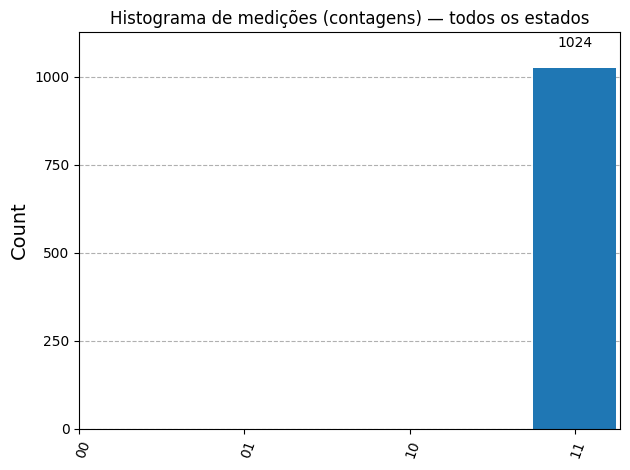

In [15]:
# 6) Histogramas
plot_histogram(full_counts, title="Histograma de medições (contagens) — todos os estados")
# plt.show()

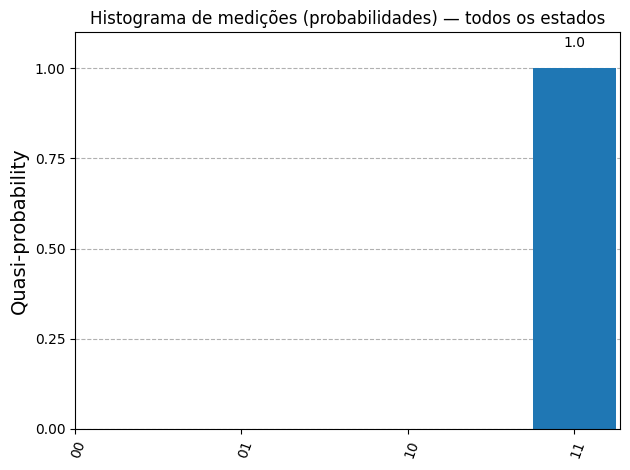

In [16]:
plot_histogram(full_probabilities, title="Histograma de medições (probabilidades) — todos os estados")
# plt.show()

In [7]:
# ============================================================
# Informações do ambiente de execução (hardware e software)
# ============================================================

import platform
import os
import shutil
import subprocess

# ----------------------------
# Sistema operacional e Python
# ----------------------------
os_info = platform.platform()
python_version = platform.python_version()

# ----------------------------
# CPU
# ----------------------------
cpu_arch = platform.machine()
cpu_cores_logical = os.cpu_count()
cpu_brand = None

try:
    system = platform.system()
    if system == "Darwin":  # macOS
        cpu_brand = subprocess.check_output(
            ["sysctl", "-n", "machdep.cpu.brand_string"]
        ).decode().strip()
    elif system == "Linux":
        with open("/proc/cpuinfo", "r") as f:
            for line in f:
                if "model name" in line:
                    cpu_brand = line.split(":", 1)[1].strip()
                    break
    elif system == "Windows":
        cpu_brand = platform.processor()
except Exception:
    cpu_brand = None

# ----------------------------
# Memória RAM
# ----------------------------
ram_total_gb = None
ram_available_gb = None

try:
    import psutil
    mem = psutil.virtual_memory()
    ram_total_gb = mem.total / (1024**3)
    ram_available_gb = mem.available / (1024**3)
except ImportError:
    # Fallback simples (macOS)
    try:
        if platform.system() == "Darwin":
            mem_bytes = int(
                subprocess.check_output(["sysctl", "-n", "hw.memsize"])
                .decode()
                .strip()
            )
            ram_total_gb = mem_bytes / (1024**3)
    except Exception:
        pass

# ----------------------------
# GPU (detecção básica)
# ----------------------------
gpu_detected = False
gpu_name = None
gpu_vendor = None

# NVIDIA (Linux/Windows)
try:
    if shutil.which("nvidia-smi"):
        out = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name", "--format=csv,noheader"],
            stderr=subprocess.DEVNULL
        ).decode().strip()
        if out:
            gpu_detected = True
            gpu_name = out.splitlines()[0]
            gpu_vendor = "NVIDIA"
except Exception:
    pass

# macOS (Metal / Apple Silicon / AMD)
try:
    if not gpu_detected and platform.system() == "Darwin":
        out = subprocess.check_output(
            ["system_profiler", "SPDisplaysDataType"],
            stderr=subprocess.DEVNULL
        ).decode(errors="ignore")
        for line in out.splitlines():
            if "Chipset Model" in line or "Model:" in line:
                gpu_detected = True
                gpu_name = line.split(":", 1)[1].strip()
                gpu_vendor = "Apple / AMD / Intel"
                break
except Exception:
    pass

# ----------------------------
# Impressão dos dados
# ----------------------------
print("=" * 65)
print("AMBIENTE DE EXECUÇÃO")
print("-" * 65)
print(f"Sistema Operacional: {os_info}")
print(f"Python: {python_version}")
print("-" * 65)
print(f"CPU: {cpu_brand or 'Não identificada'}")
print(f"Arquitetura: {cpu_arch}")
print(f"Núcleos lógicos: {cpu_cores_logical}")
print("-" * 65)

if ram_total_gb is not None:
    if ram_available_gb is not None:
        print(f"RAM total: {ram_total_gb:.2f} GB | disponível: {ram_available_gb:.2f} GB")
    else:
        print(f"RAM total: {ram_total_gb:.2f} GB")
else:
    print("RAM: não foi possível identificar")

print("-" * 65)

if gpu_detected:
    print("GPU detectada: SIM")
    print(f"GPU: {gpu_name}")
    print(f"Fornecedor: {gpu_vendor}")
else:
    print("GPU detectada: NÃO")

print("-" * 65)
print("Execução do circuito quântico: CPU (Qiskit Aer Simulator)")
print("=" * 65)

AMBIENTE DE EXECUÇÃO
-----------------------------------------------------------------
Sistema Operacional: macOS-15.6.1-arm64-arm-64bit
Python: 3.12.7
-----------------------------------------------------------------
CPU: Apple M3 Pro
Arquitetura: arm64
Núcleos lógicos: 12
-----------------------------------------------------------------
RAM total: 18.00 GB | disponível: 4.40 GB
-----------------------------------------------------------------
GPU detectada: SIM
GPU: Apple M3 Pro
Fornecedor: Apple / AMD / Intel
-----------------------------------------------------------------
Execução do circuito quântico: CPU (Qiskit Aer Simulator)


## Implementação da Busca Linear Clássica

In [8]:
import time

def linear_search_classic(target: str) -> dict:
    """
    Realiza uma busca linear clássica no espaço {0, ..., 2^n - 1}
    até encontrar o alvo especificado por uma string binária.

    A busca percorre sequencialmente todos os estados possíveis,
    comparando cada candidato com o alvo.

    Parameters
    ----------
    target : str
        String binária representando o estado alvo (ex.: "11", "10101").
        O comprimento da string define n.

    Returns
    -------
    dict
        Dicionário contendo:
        - found_index (int): valor inteiro correspondente ao alvo
        - iterations (int): número de verificações realizadas
        - execution_time (float): tempo total da busca (em segundos)
        - time_per_check (float): tempo médio por verificação clássica
    """
    if not target or any(b not in "01" for b in target):
        raise ValueError("target deve ser uma string binária válida.")

    n = len(target)
    N = 2 ** n
    target_int = int(target, 2)

    iterations = 0

    start_time = time.perf_counter()

    # Busca linear clássica
    for x in range(N):
        iterations += 1
        if x == target_int:
            break

    end_time = time.perf_counter()

    execution_time = end_time - start_time
    time_per_check = execution_time / iterations if iterations > 0 else 0.0

    return {
        "target": target,
        "target_int": target_int,
        "n": n,
        "N": N,
        "found_index": target_int,
        "iterations": iterations,
        "execution_time": execution_time,
        "time_per_check": time_per_check
    }

In [9]:
# ----------------------------
# Execução da busca linear clássica
# ----------------------------

# Chamada da função de busca clássica
classic_result = linear_search_classic(target)

# Impressão dos resultados
print("\n" + "=" * 65)
print("BUSCA CLÁSSICA LINEAR")
print("-" * 65)
print(f"Alvo (binário): |{classic_result['target']}>")
print(f"Alvo (inteiro): {classic_result['target_int']}")
print(f"n = {classic_result['n']}  |  N = {classic_result['N']}")
print(f"Índice encontrado: {classic_result['found_index']}")
print(f"Número de verificações: {classic_result['iterations']}")
print(f"Tempo total de execução: {classic_result['execution_time']:.8f} s")
print(f"Tempo médio por verificação clássica: {classic_result['time_per_check']:.8f} s")
print("=" * 65)


BUSCA CLÁSSICA LINEAR
-----------------------------------------------------------------
Alvo (binário): |11>
Alvo (inteiro): 3
n = 2  |  N = 4
Índice encontrado: 3
Número de verificações: 4
Tempo total de execução: 0.00000108 s
Tempo médio por verificação clássica: 0.00000027 s


## Relatório

In [10]:
# -------------------------------------------------
# Comparação de custo: quântico (Grover) vs clássico (linear)
# Métricas pedidas:
# - tempo médio por iteração de Grover (oráculo + difusão)
# - tempo médio por verificação clássica
# -------------------------------------------------

# Pré-requisito: você já executou os blocos anteriores e tem:
# - k, t_run (tempo do backend.run do circuito quântico) e/ou t_transpile
# - classic_result (saída de linear_search_classic)
#
# Se você usou o bloco de execução quântica que eu te passei:
# - t_run está definido
# - k está definido
# - classic_result está definido

# 1) Custo quântico por iteração de Grover
# Observação: usar t_run/k foca no "custo de execução" do circuito.
# Se quiser incluir transpile no custo, use (t_transpile + t_run)/k.
tq_per_iter_run_only = (t_run / k) if k > 0 else float("inf")
tq_per_iter_including_transpile = ((t_transpile + t_run) / k) if k > 0 else float("inf")

# 2) Custo clássico por verificação
tc_per_check = classic_result["time_per_check"]

# 3) Razões comparativas (speedup por operação)
# - Valores > 1 indicam que o denominador é menor (mais rápido)
speedup_op_run_only = (tc_per_check / tq_per_iter_run_only) if tq_per_iter_run_only > 0 else float("inf")
speedup_op_including_transpile = (tc_per_check / tq_per_iter_including_transpile) if tq_per_iter_including_transpile > 0 else float("inf")

print("\n" + "=" * 70)
print("CUSTO MÉDIO POR OPERAÇÃO (CLÁSSICO vs QUÂNTICO)")
print("-" * 70)

print("Quântico (Grover):")
print(f"- Tempo médio por iteração (oráculo + difusão) [somente run]: {tq_per_iter_run_only:.8f} s")
print(f"- Tempo médio por iteração (oráculo + difusão) [run + transpile]: {tq_per_iter_including_transpile:.8f} s")

print("\nClássico (busca linear):")
print(f"- Tempo médio por verificação: {tc_per_check:.8f} s")

print("\nComparação (custo clássico / custo quântico):")
print(f"- (tc_check / tq_iter) [somente run]: {speedup_op_run_only:.6f}  ( > 1 favorece Grover)")
print(f"- (tc_check / tq_iter) [run + transpile]: {speedup_op_including_transpile:.6f}  ( > 1 favorece Grover)")

print("=" * 70)


CUSTO MÉDIO POR OPERAÇÃO (CLÁSSICO vs QUÂNTICO)
----------------------------------------------------------------------
Quântico (Grover):
- Tempo médio por iteração (oráculo + difusão) [somente run]: 0.00119675 s
- Tempo médio por iteração (oráculo + difusão) [run + transpile]: 0.06416592 s

Clássico (busca linear):
- Tempo médio por verificação: 0.00000027 s

Comparação (custo clássico / custo quântico):
- (tc_check / tq_iter) [somente run]: 0.000226  ( > 1 favorece Grover)
- (tc_check / tq_iter) [run + transpile]: 0.000004  ( > 1 favorece Grover)


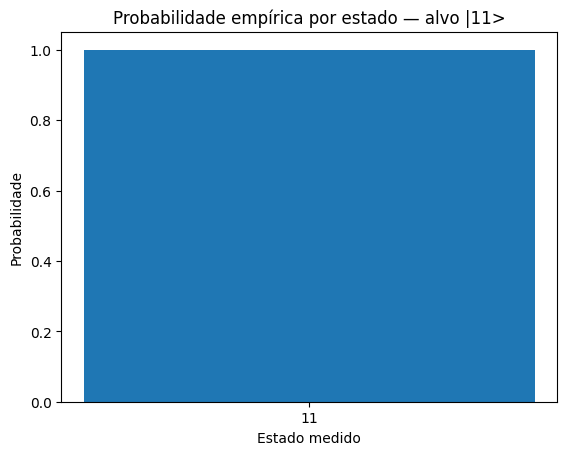

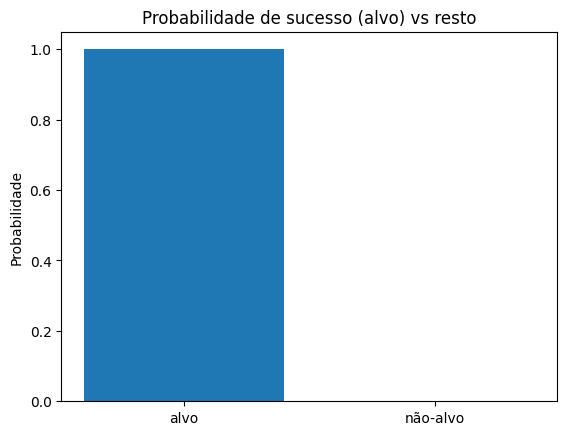

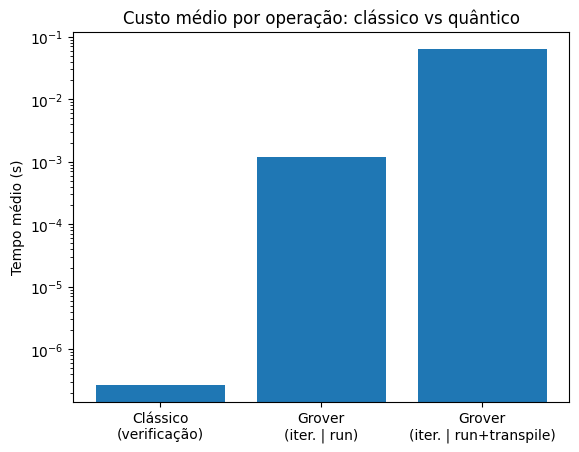

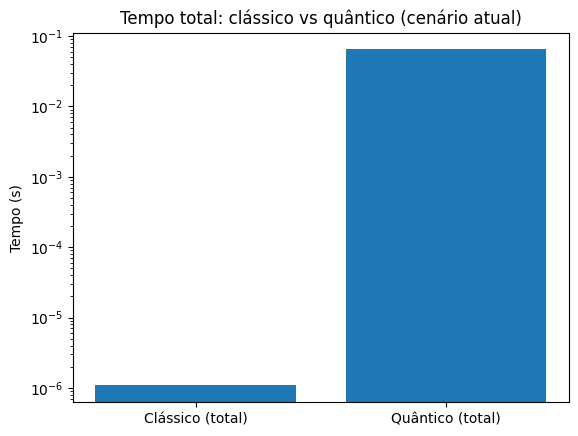

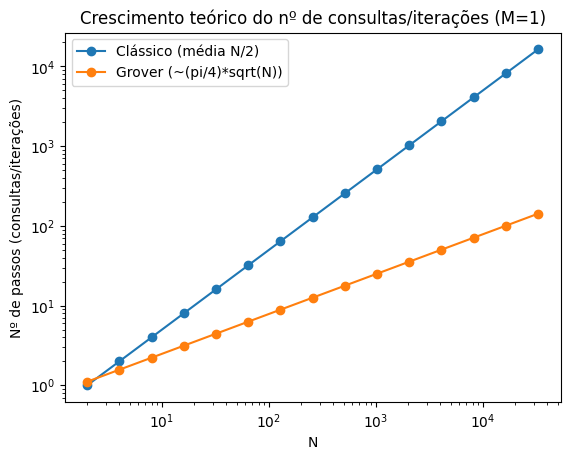


=== Resumo (opcional) ===
Top state: |11> com 1024/1024
P(|11>): 1.0000
Custo médio clássico (check): 2.70752935e-07 s
Custo médio Grover (iter, run): 1.19675000e-03 s
Custo médio Grover (iter, total): 6.41659170e-02 s


In [11]:
# ============================================================
# Gráficos para compreensão: histogramas, probabilidade e custo
# (Compatível com Qiskit atual: sem parâmetro normalize no plot_histogram)
#
# Pré-requisito: você já tem as variáveis:
# - counts (dict)            -> resultado quântico
# - target (str), shots (int)
# - k (int), t_run (float), t_transpile (float)
# - classic_result (dict)    -> resultado clássico (linear_search_classic)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# ----------------------------
# 0) Preparações úteis
# ----------------------------

# Probabilidades empíricas (normalização manual)
probabilities = {state: c / shots for state, c in counts.items()}

# Probabilidade do alvo e do não-alvo (sucesso vs resto)
p_target = probabilities.get(target, 0.0)
p_non_target = 1.0 - p_target

# Estado mais frequente
top_state, top_count = max(counts.items(), key=lambda kv: kv[1])

# Custo médio por operação
tq_iter_run_only = (t_run / k) if k > 0 else float("inf")
tq_iter_total = ((t_transpile + t_run) / k) if k > 0 else float("inf")
tc_check = classic_result["time_per_check"]

t_total_quantum = t_transpile + t_run
t_total_classic = classic_result["execution_time"]

# ============================================================
# 1) Histograma quântico (CONTAGENS) — atende ao requisito
# ============================================================

plot_histogram(
    counts,
    title=f"Histograma de medições (contagens) — alvo |{target}>",
    figsize=(8, 4)
)
plt.show()

# ============================================================
# 2) Histograma quântico (PROBABILIDADES) — normalização manual
# ============================================================

plot_histogram(
    probabilities,
    title=f"Histograma de medições (probabilidades) — alvo |{target}>",
    figsize=(8, 4)
)
plt.show()

# ============================================================
# 3) Gráfico manual de barras: Probabilidade por estado (ordenado)
# ============================================================

states_sorted = sorted(probabilities.keys())
probs_sorted = [probabilities[s] for s in states_sorted]

plt.figure()
plt.bar(states_sorted, probs_sorted)
plt.title(f"Probabilidade empírica por estado — alvo |{target}>")
plt.xlabel("Estado medido")
plt.ylabel("Probabilidade")
plt.ylim(0, 1.05)
plt.show()

# ============================================================
# 4) Destaque: alvo vs não-alvo
# ============================================================

plt.figure()
plt.bar(["alvo", "não-alvo"], [p_target, p_non_target])
plt.title("Probabilidade de sucesso (alvo) vs resto")
plt.ylabel("Probabilidade")
plt.ylim(0, 1.05)
plt.show()

# ============================================================
# 5) Comparação do custo médio por operação (escala log)
#    - clássico: tempo médio por verificação
#    - quântico: tempo médio por iteração de Grover (oráculo + difusão)
# ============================================================

labels_ops = [
    "Clássico\n(verificação)",
    "Grover\n(iter. | run)",
    "Grover\n(iter. | run+transpile)"
]
values_ops = [tc_check, tq_iter_run_only, tq_iter_total]

plt.figure()
plt.bar(labels_ops, values_ops)
plt.title("Custo médio por operação: clássico vs quântico")
plt.ylabel("Tempo médio (s)")
plt.yscale("log")  # útil quando os valores diferem por muitas ordens
plt.show()

# ============================================================
# 6) Comparação de tempo total (escala log)
# ============================================================

labels_total = ["Clássico (total)", "Quântico (total)"]
values_total = [t_total_classic, t_total_quantum]

plt.figure()
plt.bar(labels_total, values_total)
plt.title("Tempo total: clássico vs quântico (cenário atual)")
plt.ylabel("Tempo (s)")
plt.yscale("log")
plt.show()

# ============================================================
# 7) Curva teórica (intuição): passos clássicos O(N) vs Grover O(sqrt(N))
#    (Não é tempo medido; é apenas para entendimento conceitual)
# ============================================================

N_values = np.array([2**i for i in range(1, 16)])  # N = 2..32768
classic_steps = N_values / 2                        # média ~ N/2 verificações
grover_steps = (np.pi / 4) * np.sqrt(N_values)      # ~ (pi/4)*sqrt(N), M=1

plt.figure()
plt.plot(N_values, classic_steps, marker="o", label="Clássico (média N/2)")
plt.plot(N_values, grover_steps, marker="o", label="Grover (~(pi/4)*sqrt(N))")
plt.title("Crescimento teórico do nº de consultas/iterações (M=1)")
plt.xlabel("N")
plt.ylabel("Nº de passos (consultas/iterações)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

# ============================================================
# 8) Impressão resumida (opcional)
# ============================================================

print("\n=== Resumo (opcional) ===")
print(f"Top state: |{top_state}> com {top_count}/{shots}")
print(f"P(|{target}>): {p_target:.4f}")
print(f"Custo médio clássico (check): {tc_check:.8e} s")
print(f"Custo médio Grover (iter, run): {tq_iter_run_only:.8e} s")
print(f"Custo médio Grover (iter, total): {tq_iter_total:.8e} s")

## Discussão

Os resultados obtidos no cenário analisado evidenciam, de forma clara, tanto o correto funcionamento do algoritmo de Grover quanto as limitações práticas associadas à sua execução em ambientes simulados e em regimes de pequena escala. Do ponto de vista funcional, a execução do circuito quântico apresentou comportamento ideal: o estado alvo $|11\rangle$ foi observado em 100% das medições (1024/1024), indicando uma amplificação de amplitude completa após a aplicação de uma única iteração de Grover. Esse resultado confirma a correção da implementação do oráculo, do operador de difusão e do uso do qubit ancila para o mecanismo de *phase kickback*, alinhando-se rigorosamente com a formulação teórica do algoritmo.

Entretanto, a análise de desempenho temporal revela um contraste significativo entre o custo quântico e o custo clássico. Embora o tempo efetivo de execução do circuito no simulador (run) tenha sido relativamente baixo, da ordem de $1{,}20 \times 10^{-3}$ segundos, o tempo total da execução quântica é fortemente dominado pelo processo de *transpilation*, que consumiu aproximadamente $6{,}30 \times 10^{-2}$ segundos. Esse overhead representa mais de 98% do tempo total e evidencia que, em simulações clássicas, a preparação e a decomposição do circuito têm impacto muito mais relevante do que a própria simulação das operações quânticas.

Quando se considera o custo médio por operação, a diferença torna-se ainda mais expressiva. O tempo médio por verificação clássica foi da ordem de $2{,}7 \times 10^{-7}$ segundos, enquanto o tempo médio por iteração de Grover variou entre $1{,}20 \times 10^{-3}$ segundos (considerando apenas a execução) e $6{,}42 \times 10^{-2}$ segundos (considerando execução mais transpile). As razões de custo clássico por custo quântico, muito inferiores a 1, indicam que, neste cenário, a busca linear clássica é várias ordens de grandeza mais eficiente em termos de tempo de execução.

Esses resultados são coerentes com a literatura, que destaca que a vantagem do algoritmo de Grover é essencialmente assintótica. Em espaços de busca pequenos, como $N = 4$, o custo fixo associado à computação quântica — especialmente em simuladores — supera amplamente os ganhos decorrentes da redução no número de consultas ao oráculo. Além disso, deve-se ressaltar que o ambiente de execução utilizado, embora disponha de GPU e hardware moderno (Apple M3 Pro), executa o Qiskit Aer Simulator exclusivamente em CPU, não explorando paralelismo massivo em nível de hardware quântico real.

Portanto, os resultados deste experimento reforçam duas conclusões centrais. Primeiramente, o algoritmo de Grover foi validado do ponto de vista conceitual e funcional, demonstrando amplificação de amplitude correta e alta fidelidade na identificação do estado alvo. Em segundo lugar, ficou evidente que, em regimes de pequena escala e em ambientes simulados, o algoritmo quântico não apresenta vantagens práticas em relação à busca clássica linear. Esse cenário justifica a necessidade de investigar configurações com maior número de qubits, múltiplos alvos e, sobretudo, analisar o impacto de ruído e de execuções em hardware quântico real, onde o custo de *transpilation* tende a ser amortizado e a vantagem assintótica do algoritmo pode se tornar mais relevante.

